In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from tqdm import tqdm

In [ ]:
print(torch.__version__)

2.0.0+cu118


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Define File Path
# vec20avg_path = "/content/drive/MyDrive/Co-working /Thesis/vec_data/vec20_avg.npz"
# vec25avg_path = "/content/drive/MyDrive/Co-working /Thesis/vec_data/vec25_avg.npz"
vec30avg_path = "/content/drive/MyDrive/Co-working/Thesis/vec_data/vec30_avg.npz"
# vec35avg_path = "/content/drive/MyDrive/Co-working /Thesis/vec_data/vec35_avg.npz"
# vec20sum_path = "/content/drive/MyDrive/Co-working /Thesis/vec_data/vec20_sum.npz"
# vec20sum_path = "/content/drive/MyDrive/Co-working /Thesis/vec_data/vec20_sum.npz"
# vec25sum_path = "/content/drive/MyDrive/Co-working /Thesis/vec_data/vec25_sum.npz"
vec30sum_path = "/content/drive/MyDrive/Co-working/Thesis/vec_data/vec30_sum.npz"
# vec35sum_path = "/content/drive/MyDrive/Co-working /Thesis/vec_data/vec35_sum.npz"
freq_stance_labels = "/content/drive/MyDrive/Co-working/Thesis/vec_data/freq_stance_labels.npz"
oh_stance_labels = "/content/drive/MyDrive/Co-working/Thesis/vec_data/oh_stance_labels.npz"
le_stance_labels = "/content/drive/MyDrive/Co-working/Thesis/vec_data/le_stance_labels.npz"

In [ ]:
def load_npz_file(filepath):
    # Load the numpy array from the .npz file
    with np.load(filepath, allow_pickle=True) as data:
        for key in data.keys():
            arr = data[key]
            break
    return arr

In [ ]:
# vec20avg = load_npz_file(vec20avg_path)
# vec25avg = load_npz_file(vec25avg_path)
vec30avg = load_npz_file(vec30avg_path)
# vec35avg = load_npz_file(vec35avg_path)
# vec20sum = load_npz_file(vec20sum_path)
# vec20sum = load_npz_file(vec20sum_path)
# vec25sum = load_npz_file(vec25sum_path)
vec30sum = load_npz_file(vec30sum_path)
# vec35sum = load_npz_file(vec35sum_path)
freq_label = load_npz_file(freq_stance_labels)
oh_label = load_npz_file(oh_stance_labels)
le_label = load_npz_file(le_stance_labels)

In [ ]:
#指派實際要使用的Data與Label
# data = vec30avg
data = vec30sum
# label = np.argmax(oh_label, axis=1)
# label = oh_label
# label = freq_label
label = le_label

In [ ]:
print(data.shape)
print(label.shape)
print(np.unique(label))
print(np.unique(label, return_counts=True))

(445, 1, 300)
(445,)
[0 1 2 3]
(array([0, 1, 2, 3], dtype=int32), array([ 11, 188,  87, 159]))


In [ ]:
# Data Augmentation using Oversampling
# Define the oversampling ratio for each class
oversample_ratio = {0: 120, 1: 188, 2: 150, 3: 159}
# Initialize the oversampler
oversampler = RandomOverSampler(sampling_strategy=oversample_ratio)
# Reshape your data to a 2D matrix of shape (n_samples, n_features)
X = data.reshape(-1, 300)
# Apply oversampling to X and y
X_resampled, y_resampled = oversampler.fit_resample(X, label)
# Reshape X back to its original shape
X_resampled = X_resampled.reshape(-1, 1, 300)

In [ ]:
# print(X_resampled.shape)
# print(X_resampled)

In [ ]:
# print(y_resampled.shape)
# print(y_resampled)

In [ ]:
# Create Label weights used in the Pytorch Loss Function
# Max(np.unique(label)/Label counts for every idx
# weights = [17.09, 1.0, 2.16, 1.18]
# Because My Dataset is extremely imbalanced, so we need to use weight on Loss Function.
# https://discuss.pytorch.org/t/dealing-with-imbalanced-datasets-in-pytorch/22596
# https://discuss.pytorch.org/t/what-is-the-weight-values-mean-in-torch-nn-crossentropyloss/11455/10
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
# Using original data
# train_data, test_data, train_labels, test_labels = train_test_split(data, label, test_size=0.2)
# Using oversampling data
train_data, test_data, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.3)
print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)
print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)

Train data shape: (431, 1, 300)
Train labels shape: (431,)
Test data shape: (186, 1, 300)
Test labels shape: (186,)


### Note
注意:資料集不平衡!!
+ Hostile: 11
+ Proactive: 87
+ Neutral: 159
+ Unrelated: 188

In [ ]:
# Convert the data and labels to PyTorch tensors
train_data_tensor = torch.from_numpy(train_data).float()
train_labels_tensor = torch.from_numpy(train_labels).long()
test_data_tensor = torch.from_numpy(test_data).float()
test_labels_tensor = torch.from_numpy(test_labels).long()

In [ ]:
print(train_data_tensor.shape)
print(test_data_tensor.shape)
print(train_labels_tensor.shape)
print(test_labels_tensor.shape)

torch.Size([431, 1, 300])
torch.Size([186, 1, 300])
torch.Size([431])
torch.Size([186])


In [ ]:
# Create a TensorDataset for each set of data and labels
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

In [ ]:
# Create a DataLoader for each dataset to batch and shuffle the data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=5)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64 * 73, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        print(x.shape)
        x = x.view(-1, 64 * 73)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Trainging Settings
num_classes = 4
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
# Define Loss Function weights
# class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=class_weights) # Using weight
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping Settings
# Define the number of epochs to wait before stopping if the test accuracy does not improve
patience = 3
# Initialize the counter for the number of epochs without improvement
counter = 0
# Initialize the best test accuracy to zero
best_val_accuracy = 0.0

# Epochs and records
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target.squeeze().to(torch.long))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target.squeeze().long()).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = 100.0 * train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target.squeeze().to(torch.long))
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_correct += (predicted == target.squeeze().long()).sum().item()
        val_loss /= len(test_loader)
        val_accuracy = 100.0 * val_correct / len(test_dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    print('Epoch: {} \tTrain Loss: {:.6f} \tTrain Accuracy: {:.2f}% \tVal Loss: {:.6f} \tVal Accuracy: {:.2f}%'.format(
          epoch, train_loss, train_accuracy, val_loss, val_accuracy))
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping at epoch", epoch)
            break

torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([15, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([26, 64, 73])
Epoch: 0 	Train Loss: 1.427645 	Train Accuracy: 44.08% 	Val Loss: 1.231158 	Val Accuracy: 58.06%
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
torch.Size([15, 64, 73])
torch.Size([32, 64, 73])
torch.Size([32, 64, 73])
tor

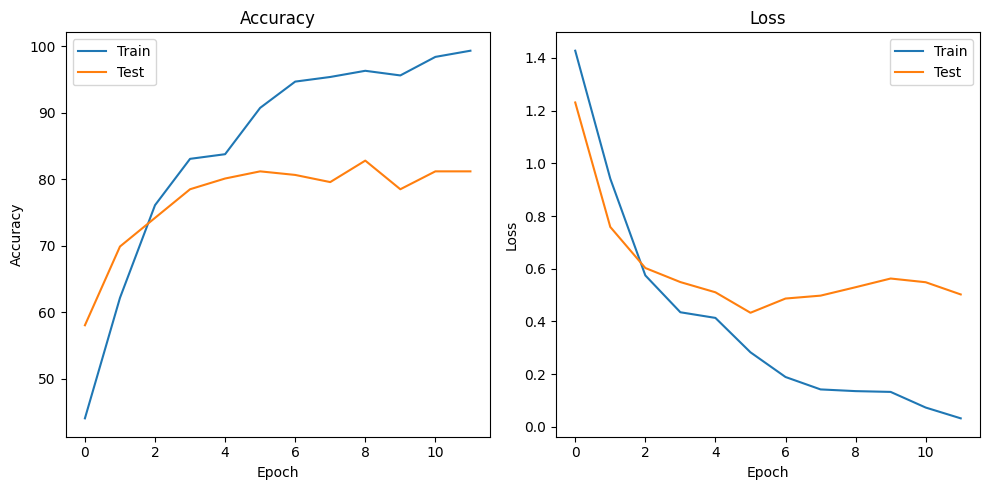

In [ ]:
# Plot the train and test accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(train_accuracies, label='Train')
ax1.plot(val_accuracies, label='Test')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(train_losses, label='Train')
ax2.plot(val_losses, label='Test')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.savefig('vec30_sum_230417.PNG', dpi=300)
plt.show()

In [ ]:
print(train_accuracies)
print(val_accuracies)

In [ ]:
#儲存結果好的Resample到NPZ
save_x = {'X_resampled': np.array(X_resampled)}
np.savez_compressed('X_resampled.npz', **save_x)
save_y = {'y_resampled': np.array(y_resampled)}
np.savez_compressed('y_resampled.npz', **save_y)

In [ ]:
#儲存結果好的Split Data到NPZ
train_x = {'train_data': np.array(train_data)}
np.savez_compressed('train_data.npz', **train_x)
train_y = {'train_labels': np.array(train_labels)}
np.savez_compressed('train_labels.npz', **train_y)
test_x = {'test_data': np.array(test_data)}
np.savez_compressed('test_data.npz', **test_x)
test_y = {'test_labels': np.array(test_labels)}
np.savez_compressed('test_labels.npz', **test_y)

In [ ]:
#Save Model Parameter
torch.save(model, 'cnn_vec30sum.pt')